# Real Time Object Detection with YOLO and OpenCV

YOLO is a deep learning algorithm and a state-of-the-art real time object detection algorithm which came out in May 2016. It is so popular because it is so fast compared with the other deep learning object detection models.

In traditional methods we use windows to calculate scores within a image. We use the highest score to say there is an object. YOLO uses different methods. It uses bounding boxes (anchors) to determine the objects in the image with the help of neural network. It uses probabilities of the boxes. It is assumed that a box with highest score detects the object. Neural network sees image just once. That'S why YOLO algorims is called "You only look once algorithm".

![Screenshot%202020-07-20%20at%2019.09.43.png](attachment:Screenshot%202020-07-20%20at%2019.09.43.png)
Resource:(https://pjreddie.com/media/files/papers/YOLOv3.pdf)

It can be seen from above picture that YOLO3 is at least 3 times faster than the others.

YOLO3 accepts three different input forms as Image file, webcam feed and video file.

We will use pre-trained YOLOv3 algorithm and it's weights. It is capable of detecting 80 different objects such as person, bicycle and car.

For transfer learning we need to:
* download weight file of YOLO
* download configuration file of YOLO
* download name file - coco
* install OpenCV 3.4.2 or above




**---------------------------------------------------------**
* download config file: https://github.com/pjreddie/darknet/tree/master/cfg
* download weights: https://pjreddie.com/darknet/yolo/
* download coco.names:https://github.com/pjreddie/darknet/blob/master/data/coco.names
* !pip install opencv-python





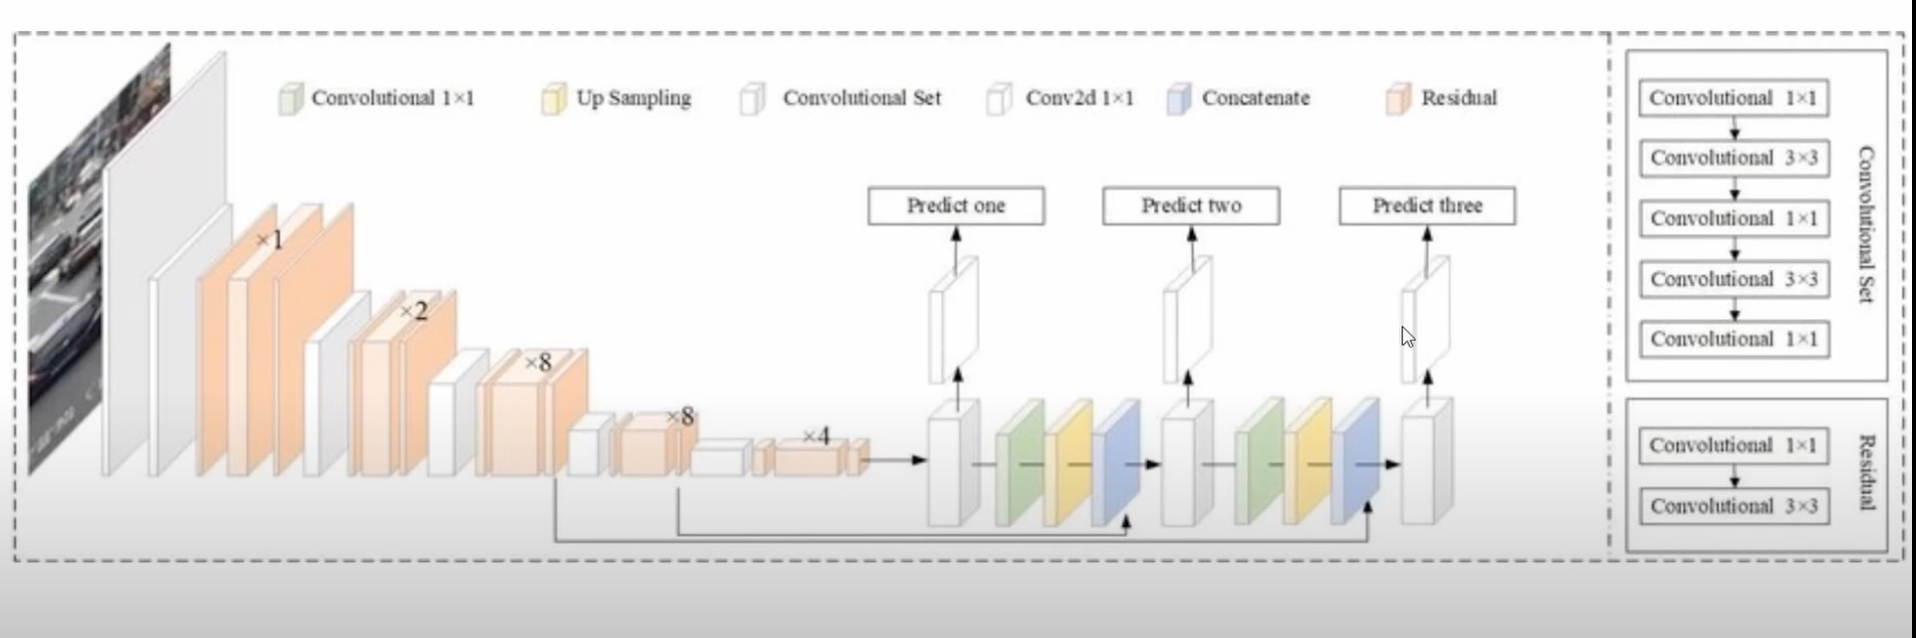

In [ ]:
import cv2
import numpy as np



# we are loading yolo weights, configuration and object names.
# Open cv nin bu fonksiyonu weights leri yüklemek ve configürasyonu yapmak için yazılmıştır. Bu bize model objesi 
# dönecek ve bunu daha sonra predictions yapmak için kullanacağız.
net = cv2.dnn.readNet('/Users/muhammet/Desktop/yolo3_nesne_tanima/yolov3.weights', '/Users/muhammet/Desktop/yolo3_nesne_tanima/yolov3.cfg')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)   # urada open cv yi kullanacağımızı söylüyoruz.
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)   # burada da cpu y kullanacağımızı belirtiyoruz.



# coco.names den object names leri extract edelim ve bunları classes diye bir listeye alalım

classes = []
with open('/Users/muhammet/Desktop/yolo3_nesne_tanima/coco.names', 'r') as f:
    classes = f.read().splitlines()

# Şimdi kendi seçtiğimiz bir foto üzerinden gidelim. 
# Bu fotounun size ını 416x416 boyutuna indirgeyip, 255' e bölerek scale edeceğiz.




# resim kullanmak için
img = cv2.imread('/Users/muhammet/Desktop/yolo3_nesne_tanima/image1.jpg')  # fotoyu folderdan okur.




# Burada image i blob a çeviriyoruz. YANİ numpy.ndarray FORMATINA ÇEVİRİYORUZ
# swapRB=True BGR olan renk sırasını RGB ye cevirir. burada 1 değerini silip swapRB de yazılabilir.
blob = cv2.dnn.blobFromImage(img, 1/255, (416,416), [0,0,0],1, crop=False)


# bu fotoyu düzenledikten sonra modele input olarak veriyotuz
net.setInput(blob)

# tahmin değerleri  , boxes dimensions ya da tahmin sınıfları gibi bilgileri almak için output layer ın ismini alıp
# forward functiona bu ismi girdi vermeliyiz. yukarıda resimde degörüldüğü gibi 3 output layer var.
# Bütün layerları görmek isterseniz  layerNames = net.getLayerNames()    yazabilirsiniz.
output_layers_names = net.getUnconnectedOutLayersNames()
layer_outputs = net.forward(output_layers_names)  # Layeroutput daki boxes ve prediction değerlerini numpy array olarak tutar.
# Burada bütün hesaplamalar yapıldı ve layer_outputs içinde bütün boxes ve prediction değerleri var.
# Şimdi bunları ayıralım









# Boxes 
height, width, _ = img.shape    # fotonun boyutlarını tutar. _ burada fotonun renk sayısını tutar ve 3 tür.
boxes = []
confidences = []
class_ids = []

# buradaki detectionın ilk 4 değeri box boyutunu, 5. değeri nesne olasılığını ve diğerleri 80 sınıf olasılığını verir.
# yani toplamda 85 değeri tutuyor.
for output in layer_outputs:
    for detection in output:
        scores = detection[5:] # sınıfların olasılıklarını tutar.
        class_id = np.argmax(scores) # en yüksek skorun locasyonunu tutar yani indexini tutar.
        confidence = scores[class_id] # en yüksek olasılık değerini alır.
        # burada confidence ı alıyoruz çünkü bunu bir eşikle kabul edip etmeyeceğimize karar vereceğiz.
        threshold = 0.5
        if confidence > threshold:
        # x ve y boxes ın x ve y eksenin tam orta nokasıdır.width nesnenin genişliği(x ekseni), height boyu (y ekseni)
        # Bunları yukarıda girdi verdiğimiz resim boyutları ile çarparız ve kutunun resimdeki gerçek yerini buluruz.
            center_x = int(detection[0]*width)
            center_y = int(detection[1]*height)
            w = int(detection[2]*width)         # width
            h = int(detection[3]*height)         # height
        
        
            # box ın sol üst köşesini belirleyelim
            x = int(center_x - w/2)
            y = int(center_y - h/2)
    
            boxes.append([x, y, w, h])
            confidences.append((float(confidence)))
            class_ids.append(class_id)
    # Bütün gerekli bilgileri almış olduk.
    

    
    
    

    
# bir objeyi birden fazla boxes işaretlemiş olabilir. Bu durumda non-maximum suppressions kullanılır ve
# en yüksek olasılıklı olan alınır
# 0.4 non-max suppresiion degeridir.
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)


font = cv2.FONT_HERSHEY_PLAIN    # kutuların üzerindeki yazıların fontunu belirler.
colors = np.random.uniform(0, 255, size = (len(boxes),3))   # kutuların renklerini belirler

for i in range(len(boxes)):
    
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence = str(round(confidences[i],2))
        color = colors[i]
        cv2.rectangle(img, (x, y), (x+w, y+(h)), color, 2) # box ın boyutunu ve obje üzerindeki yerini veriyoruz.2 değeri box ın çizgi kalınlığını veriri.
        cv2.putText(img, label + " "+ confidence, (x, y-10), font, 1.2, color, 2) # obje üstündeki texti verir.



# fotoyu görmek istersek

cv2.imshow('Image', img)
cv2.waitKey(0)  # bu kaç milisecond bekleyeceğimizi söyler.
cv2.destroyAllWindows()